In [1]:
import json
import pandas_datareader as web #Get data
import numpy as np #Matrix operation
import pandas as pd #Dataframes
from sklearn.preprocessing import MinMaxScaler #Normalization
import matplotlib.pyplot as plt #Graphs
import datetime #Today's date
from sklearn.metrics import mean_squared_error #RMSE ERROR
from tensorflow.keras.models import load_model

In [2]:
#read Json file and choose one model

with open('data.json') as json_file:
    data = json.load(json_file)

corp="Facebook"
stock=[model for model in data['models'] if model['corp']==corp][0]
stock

{'corp': 'Facebook',
 'name': 'FB',
 'startTraining': '2015-01-01',
 'endTraining': '2019-11-29',
 'n_rows': 1236,
 'model': 'FB.h5',
 'rmse': 8.572490617347103}

In [3]:
#Testing the model in real time data
#Get the data of Corp choosed. Using yahoo finance as source and last 5 years

today=datetime.datetime.now().strftime("%Y-%m-%d")
df=web.DataReader(stock['name'],
                  data_source='yahoo',
                  start=stock['startTraining'],
                  end=today)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-02-17,273.970001,269.579987,271.239990,273.570007,12749500,273.570007
2021-02-18,271.950012,266.029999,269.570007,269.390015,15221400,269.390015
2021-02-19,270.269989,260.149994,269.859985,261.559998,25549900,261.559998
2021-02-22,263.070007,257.529999,257.950012,260.329987,17382300,260.329987
2021-02-23,265.619995,254.960007,259.500000,262.410004,12491943,262.410004


In [4]:
#load Keras Model
model=load_model(f"models/{stock['model']}")

In [5]:
#predict prices after training an test data (realtime)

df2=df.reset_index()
n_rows=df2.loc[df2['Date']==stock['endTraining']].index[0]
data=df[n_rows-60:].filter(['Close'])
data

,Close
Date,
2019-09-05,190.899994
2019-09-06,187.490005
2019-09-09,188.759995
2019-09-10,186.169998
2019-09-11,188.490005
...,...
2021-02-17,273.570007
2021-02-18,269.390015
2021-02-19,261.559998


In [6]:
#Y values (real values)
y=data[60:]
y=np.array(y)
y.shape

(310, 1)

In [7]:
#MinMax Scaler for x matrix
scaler=MinMaxScaler(feature_range=(0,1))
scaled_x=scaler.fit_transform(data)

In [8]:
#x values (last 60 days)
x=[]
for i in range(60,len(scaled_x)):
    x.append(scaled_x[i-60:i,0])
x=np.array(x)

In [9]:
x[-1],y[-1]

(array([0.8290691 , 0.82064594, 0.83470548, 0.82938568, 0.8900569 ,
        0.89620004, 0.86029135, 0.84667517, 0.88391377, 0.87010761,
        0.83540222, 0.83033561, 0.80772632, 0.81177961, 0.82039256,
        0.8211527 , 0.81361627, 0.82577576, 0.80291328, 0.76681441,
        0.77327412, 0.76877766, 0.82957567, 0.82818237, 0.79708672,
        0.8052565 , 0.77853072, 0.79138695, 0.74287521, 0.77726402,
        0.76985437, 0.70189991, 0.66548446, 0.66896769, 0.63096896,
        0.66719443, 0.72887907, 0.76928442, 0.80341984, 0.81374286,
        0.83597218, 0.86155786, 0.79879679, 0.75357821, 0.7113362 ,
        0.73464223, 0.76675101, 0.76402782, 0.76301449, 0.77321092,
        0.76358445, 0.78176067, 0.79708672, 0.78771382, 0.78841038,
        0.81038632, 0.80785311, 0.7813807 , 0.73179225, 0.72400244]),
 array([262.41000366]))

In [10]:
#Reshape
x=np.reshape(x,(x.shape[0],x.shape[1],1))
x.shape

(310, 60, 1)

In [11]:
#Get predicted scaled prices
pred_price=model.predict(x)
predictions=scaler.inverse_transform(pred_price)
_df=df[n_rows:].filter(['Close'])
_df['Predictions']=predictions
_df.tail(10)

,Close,Predictions
Date,,
2021-02-09,269.450012,264.085999
2021-02-10,271.869995,266.751831
2021-02-11,270.390015,269.115845
2021-02-12,270.500000,267.565643
2021-02-16,273.970001,267.448578
2021-02-17,273.570007,270.769318
2021-02-18,269.390015,270.393738
2021-02-19,261.559998,266.156067
2021-02-22,260.329987,258.327759


In [12]:
#RMSE using ScikitLearn
rmse=mean_squared_error(_df['Close'],_df['Predictions'],squared=False)
rmse

6.2882840221583765

In [13]:
#Predict Tomorrow price
xt=scaled_x[-60:]
xt=np.reshape(xt,(1,60,1))
yt1=scaler.inverse_transform(model.predict(xt))
yt1

array([[259.61072]], dtype=float32)

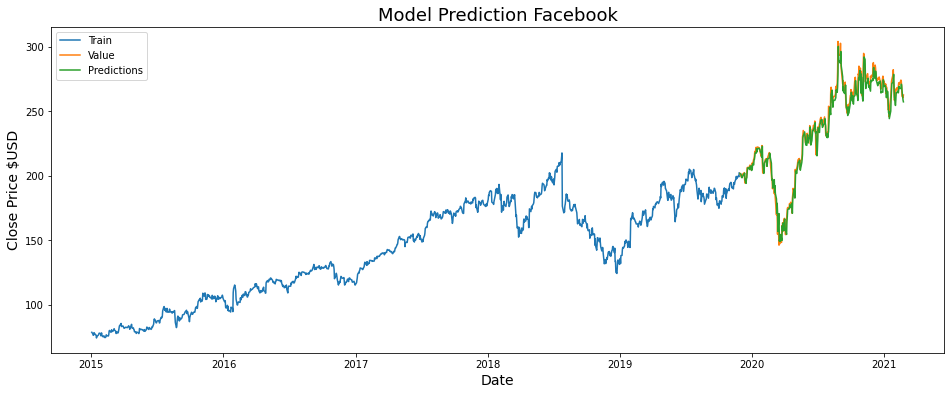

In [20]:
#PLot data and predictions
fig=plt.figure(figsize=(16,6))
plt.title(f"Model Prediction {corp}",fontsize=18)
plt.xlabel('Date',fontsize=14)
plt.ylabel("Close Price $USD",fontsize=14)
plt.plot(df[:n_rows]['Close'])
plt.plot(_df[['Close','Predictions']])
plt.legend(['Train','Value','Predictions'])
plt.show()